* changed by nov05 on 2024-11-24   
* I completed this notebook on my local computer.   
* Find the code for the 3 Lambda functions in `.\lambda.py`.  
* Set up AWS credentials
    * In Windows `Powershell`  
        ```bash
        $ Resolve-Path ~  
        $ notepad C:\Users\*\.aws\credentials  
        ```  
    * Add `aws_access_key_id`, `aws_secret_access_key`, and `aws_session_token` (if needed)  
        ```bash  
        $ cat ~/.aws/credentials  
        ```  

In [73]:
## reset the session after updating credentials
import boto3
boto3.DEFAULT_SESSION = None

import sagemaker # type: ignore
from sagemaker import get_execution_role # type: ignore
from sagemaker.session import Session # type: ignore

role_arn = get_execution_role()  ## get role ARN
if 'AmazonSageMaker-ExecutionRole' not in role_arn:
    ## your own role here
    role_arn = "arn:aws:iam::807711953667:role/service-role/AmazonSageMaker-ExecutionRole-20241121T213663"
print("Role ARN:", role_arn) ## If local, Role ARN: arn:aws:iam::807711953667:role/voclabs
session = sagemaker.Session()
region = session.boto_region_name
bucket = session.default_bucket()

print("AWS Region: {}".format(region))
print("Default Bucket: {}".format(bucket))
print("Role Arn: {}".format(role_arn))

[11/27/24 02:00:25] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=384454;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=814195;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

[11/27/24 02:00:27] WARNING  Couldn't call 'get_role' to get Role ARN from role name voclabs to get ]8;id=482963;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=842247;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py#5902\5902]8;;\
                             Role path.                                                                            

Role ARN: arn:aws:iam::807711953667:role/service-role/AmazonSageMaker-ExecutionRole-20241121T213663


                    INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=628156;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=758165;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

AWS Region: us-east-1
Default Bucket: sagemaker-us-east-1-807711953667
Role Arn: arn:aws:iam::807711953667:role/service-role/AmazonSageMaker-ExecutionRole-20241121T213663


# **Deploy and monitor a machine learning workflow for Image Classification**

## Setting up this notebook

Notes about the instance size and kernel setup: this notebook has been tested on

1. The `Python 3 (Data Science)` kernel
2. The `ml.t3.medium` Sagemaker notebook instance

## Data Staging

We'll use a sample dataset called CIFAR to simulate the challenges Scones Unlimited are facing in Image Classification. In order to start working with CIFAR we'll need to:

1. Extract the data from a hosting service
2. Transform it into a usable shape and format
3. Load it into a production system

In other words, we're going to do some simple ETL!

### 1. Extract the data from the hosting service

In the cell below, define a function `extract_cifar_data` that extracts python version of the CIFAR-100 dataset. The CIFAR dataaset is open source and generously hosted by the University of Toronto at: https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz 

In [ ]:
import requests
def extract_cifar_data(url="https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz",
                       filename="cifar.tar.gz"):
    """
    A function for extracting the CIFAR-100 dataset and storing it as a gzipped file
    Arguments:
    url      -- the URL where the dataset is hosted
    filename -- the full path where the dataset will be written
    """
    # Todo: request the data from the data url
    # Hint: use `requests.get` method
    response = requests.get(url)
    with open(filename, "wb") as file_context:
        file_context.write(response.content)
    return

Let's test it out! Run the following cell and check whether a new file `cifar.tar.gz` is created in the file explorer.

In [ ]:
extract_cifar_data("https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz")   
## $ rm project\cifar.tar.gz  
## 29.4s, 161 MB

### 2. Transform the data into a usable shape and format

Clearly, distributing the data as a gzipped archive makes sense for the hosting service! It saves on bandwidth, storage, and it's a widely-used archive format. In fact, it's so widely used that the Python community ships a utility for working with them, `tarfile`, as part of its Standard Library. Execute the following cell to decompress your extracted dataset:

In [ ]:
import tarfile
with tarfile.open("cifar.tar.gz", "r:gz") as tar:
    tar.extractall()
## project\cifar-100-python\

A new folder `cifar-100-python` should be created, containing `meta`, `test`, and `train` files. These files are `pickles` and the [CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html) provides a simple script that can be used to load them. We've adapted the script below for you to run:

In [5]:
import pickle
with open("./cifar-100-python/meta", "rb") as f:
    dataset_meta = pickle.load(f, encoding='bytes')
with open("./cifar-100-python/test", "rb") as f:
    dataset_test = pickle.load(f, encoding='bytes')
with open("./cifar-100-python/train", "rb") as f:
    dataset_train = pickle.load(f, encoding='bytes')

In [44]:
# Feel free to explore the datasets
print(dataset_meta.keys())
print(dataset_train.keys())

dict_keys([b'fine_label_names', b'coarse_label_names'])
dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])


In [49]:
print(f"There are {len(dataset_train[b'filenames'])} files.")
print(f"There are {len(set(dataset_train[b'batch_label']))} batch labels.")
print(f"There are {len(set(dataset_train[b'fine_labels']))} fine labels.")
print(f"There are {len(set(dataset_train[b'coarse_labels']))} coarse labels.")
print(f"There are {len(dataset_meta[b'fine_label_names'])} fine label names.")
print(f"There are {len(dataset_meta[b'coarse_label_names'])} coarse label names.")

There are 50000 files.
There are 13 batch labels.
There are 100 fine labels.
There are 20 coarse labels.
There are 100 fine label names.
There are 20 coarse label names.


As documented on the homepage, `b'data'` contains rows of 3072 unsigned integers, representing three channels (red, green, and blue) for one 32x32 pixel image per row.

In [19]:
print("32*32*3 =", 32*32*3)
print(len(dataset_train[b'data'][0]))

32*32*3 = 3072
3072


For a simple gut-check, let's transform one of our images. Each 1024 items in a row is a channel (red, green, then blue). Each 32 items in the channel are a row in the 32x32 image. Using python, we can stack these channels into a 32x32x3 array, and save it as a PNG file:

In [20]:
import numpy as np

# Each 1024 in a row is a channel (red, green, then blue)
row = dataset_train[b'data'][0]
red, green, blue = row[0:1024], row[1024:2048], row[2048:]

# Each 32 items in the channel are a row in the 32x32 image
red = red.reshape(32,32)
green = green.reshape(32,32)
blue = blue.reshape(32,32)

# Combine the channels into a 32x32x3 image!
combined = np.dstack((red,green,blue))

For a more concise version, consider the following:

In [21]:
# All in one:
test_image = np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))

In [ ]:
## use this one
test_image_too = np.transpose(
    np.array(row).reshape(3, 32, 32), 
    axes=(1, 2, 0)
)
np.array_equal(test_image, test_image_too)

True

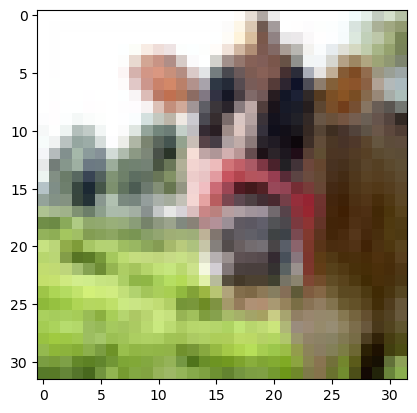

In [22]:
import matplotlib.pyplot as plt
plt.imshow(test_image);

Looks like a cow! Let's check the label. `dataset_meta` contains label names in order, and `dataset_train` has a list of labels for each row.

In [23]:
dataset_train[b'fine_labels'][0]

19

Our image has a label of `19`, so let's see what the 19th item is in the list of label names.

In [24]:
print(dataset_meta[b'fine_label_names'][19])

b'cattle'


Ok! 'cattle' sounds about right. By the way, using the previous two lines we can do:

In [45]:
print(dataset_meta[b'fine_label_names'][dataset_train[b'fine_labels'][0]])

b'cattle'


Now we know how to check labels, is there a way that we can also check file names? `dataset_train` also contains a `b'filenames'` key. Let's see what we have here:

In [28]:
print(dataset_train[b'filenames'][0])

b'bos_taurus_s_000507.png'


"Taurus" is the name of a subspecies of cattle, so this looks like a pretty reasonable filename. To save an image we can also do:

In [ ]:
## '.\bos_taurus_s_000507.png' should be created
plt.imsave(dataset_train[b'filenames'][0].decode('utf-8'), test_image)

Your new PNG file should now appear in the file explorer -- go ahead and pop it open to see!

Now that you know how to reshape the images, save them as files, and capture their filenames and labels, let's just capture all the bicycles and motorcycles and save them. Scones Unlimited can use a model that tells these apart to route delivery drivers automatically.

In the following cell, identify the label numbers for Bicycles and Motorcycles:

In [ ]:
import pandas as pd
# Todo: Filter the dataset_train and dataset_meta objects to find the label numbers for Bicycle and Motorcycle
s = pd.Series(dataset_meta[b'fine_label_names'])
print("the label number for Bicycle:", s[s==b'bicycle'].index.values[0])
print("the label number for Motorcycle:", s[s==b'motorcycle'].index.values[0])


the label number for Bicycle: 8
the label number for Motorcycle: 48


Good job! We only need objects with label 8 and 48 -- this drastically simplifies our handling of the data! Below we construct a dataframe for you, and you can safely drop the rows that don't contain observations about bicycles and motorcycles. Fill in the missing lines below to drop all other rows:

In [125]:
# Construct the dataframe
df_train = (
    pd.DataFrame({
        "filenames": dataset_train[b'filenames'],
        "labels": dataset_train[b'fine_labels'],})
    .reset_index()
    .rename(columns={'index': 'row'}) 
)
# Drop all rows from df_train where label is not 8 or 48
df_train = df_train.loc[
    (df_train['labels']==8) | 
    (df_train['labels']==48)
] #TODO: Fill in

# Decode df_train.filenames so they are regular strings
df_train["filenames"] = df_train["filenames"].apply(
    lambda x: x.decode("utf-8")
)
df_test = (
    pd.DataFrame({
        "filenames": dataset_test[b'filenames'],
        "labels": dataset_test[b'fine_labels'],})
    .reset_index()
    .rename(columns={'index': 'row'})
)
# Drop all rows from df_test where label is not 8 or 48
df_test = df_test.loc[
    (df_test['labels']==8) | 
    (df_test['labels']==48)
] #TODO: Fill in

# Decode df_test.filenames so they are regular strings
df_test["filenames"] = df_test["filenames"].apply(
    lambda x: x.decode("utf-8")
)

In [126]:
## check the result
df_train.sample(3)

,row,filenames,labels
46157,46157,cycle_s_002503.png,8
3464,3464,minibike_s_001972.png,48
9455,9455,minibike_s_000149.png,48


Now that the data is filtered for just our classes, we can save all our images.

In [93]:
# !mkdir ./train
# !mkdir ./test
import os
local_path_train = './train'
local_path_test = './test'
# Create directories if they don't exist
os.makedirs(local_path_train, exist_ok=True)
os.makedirs(local_path_test, exist_ok=True)

In the previous sections we introduced you to several key snippets of code:

1. Grabbing the image data:

```python
dataset_train[b'data'][0]
```

2. A simple idiom for stacking the image data into the right shape

```python
np.transpose(
    np.array(row).reshape(3, 32, 32), 
    axes=(1, 2, 0)
)
```

3. A simple `matplotlib` utility for saving images

```python
plt.imsave(path+row['filenames'], target)
```

Compose these together into a function that saves all the images into the `./test` and `./train` directories. Use the comments in the body of the `save_images` function below to guide your construction of the function:


In [127]:
def save_image(dataset, df_row, path):
    try:
        # Grab the image data in row-major form
        # Consolidated stacking/reshaping from earlier
        img = np.transpose(
            np.array(dataset[b'data'][df_row['row']]).reshape(3, 32, 32), 
            axes=(1, 2, 0)
        )
        # Save the image
        plt.imsave(
            path + '/' + dataset[b'filenames'][df_row['row']].decode('utf-8'), 
            img
        )
    except Exception as e:
        print(e)
        return False
    # Return any signal data you want for debugging
    return True

## test processing one row of df_train
## ".\train\bike_s_000682.png" should be created
save_image(dataset_train, df_train.iloc[0], local_path_train)

True

In [128]:
## TODO: save ALL images using the save_images function
df_train.apply(
    lambda df_row: save_image(dataset_train, df_row, local_path_train),
    axis=1
)
df_test.apply(
    lambda df_row: save_image(dataset_test, df_row, local_path_test),
    axis=1
)

27      True
28      True
116     True
161     True
319     True
        ... 
9654    True
9692    True
9833    True
9928    True
9939    True
Length: 200, dtype: bool

In [129]:
## verify results
from pathlib import Path
print(len([f for f in Path(local_path_train).iterdir() if f.is_file()])==df_train.shape[0])
print(len([f for f in Path(local_path_test).iterdir() if f.is_file()])==df_test.shape[0])

True
True


### 3. Load the data

Now we can load the data into S3.

Using the sagemaker SDK grab the current region, execution role, and bucket.

🟢 Tips:   
* In Windows `Powershell`  
    ```bash
    $ Resolve-Path ~  
    $ notepad C:\Users\*\.aws\credentials  
    ```  
* Add `aws_access_key_id`, `aws_secret_access_key`, and `aws_session_token` (if needed)  
    ```bash  
    $ cat ~/.aws/credentials  
    ```  

In [ ]:
## reset the session after updating credentials
import boto3
boto3.DEFAULT_SESSION = None

import sagemaker # type: ignore
from sagemaker import get_execution_role # type: ignore
from sagemaker.session import Session # type: ignore

role_arn = get_execution_role()  ## get role ARN
if 'AmazonSageMaker-ExecutionRole' not in role_arn:
    ## your own role here
    role_arn = "arn:aws:iam::807711953667:role/service-role/AmazonSageMaker-ExecutionRole-20241121T213663"
print("Role ARN:", role_arn) ## If local, Role ARN: arn:aws:iam::807711953667:role/voclabs
session = sagemaker.Session()
region = session.boto_region_name
bucket = session.default_bucket()

print("AWS Region: {}".format(region))
print("Default Bucket: {}".format(bucket))
print("Role Arn: {}".format(role_arn))

[11/26/24 00:31:46] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=156933;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=58783;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

[11/26/24 00:31:48] WARNING  Couldn't call 'get_role' to get Role ARN from role name voclabs to get ]8;id=713227;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=413429;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py#5902\5902]8;;\
                             Role path.                                                                            

Role ARN: arn:aws:iam::807711953667:role/service-role/AmazonSageMaker-ExecutionRole-20241121T213663


                    INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=683195;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=69622;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

AWS Region: us-east-1
Default Bucket: sagemaker-us-east-1-807711953667
Role Arn: arn:aws:iam::807711953667:role/service-role/AmazonSageMaker-ExecutionRole-20241121T213663


With this data we can easily sync your data up into S3!

In [ ]:
import os
os.environ["DEFAULT_S3_BUCKET"] = bucket
# !aws s3 sync ./train s3://${DEFAULT_S3_BUCKET}/train/
# !aws s3 sync ./test s3://${DEFAULT_S3_BUCKET}/test/
## Windows OS
os.system(f'aws s3 sync ./train s3://{os.environ["DEFAULT_S3_BUCKET"]}/train/')
os.system(f'aws s3 sync ./test s3://{os.environ["DEFAULT_S3_BUCKET"]}/test/')
## go to AWS S3. all the pictures should have been uploaded to the bucket

0

And that's it! You can check the bucket and verify that the items were uploaded.

## Model Training

For Image Classification, Sagemaker [also expects metadata](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html) e.g. in the form of TSV files with labels and filepaths. We can generate these using our Pandas DataFrames from earlier:

In [130]:
def to_metadata_file(df, prefix):
    df["s3_path"] = df["filenames"]
    df["labels"] = df["labels"].apply(lambda x: 0 if x==8 else 1)
    return df[["row", "labels", "s3_path"]].to_csv(
        f"{prefix}.lst", sep="\t", index=False, header=False
    ) 
to_metadata_file(df_train.copy(), "train")
to_metadata_file(df_test.copy(), "test")

We can also upload our manifest files:

In [131]:
import boto3
# Upload files
boto3.Session().resource('s3').Bucket(
    bucket).Object('train.lst').upload_file('./train.lst')
boto3.Session().resource('s3').Bucket(
    bucket).Object('test.lst').upload_file('./test.lst')

[11/25/24 15:40:29] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=215586;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=201840;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

[11/25/24 15:40:30] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=658976;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=139549;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

Using the `bucket` and `region` info we can get the latest prebuilt container to run our training job, and define an output location on our s3 bucket for the model. Use the `image_uris` function from the SageMaker SDK to retrieve the latest `image-classification` image below:

In [135]:
# Use the image_uris function to retrieve the latest 'image-classification' image 
algo_image = sagemaker.image_uris.retrieve("image-classification", region, version='latest') ## TODO: fill in
s3_model_output = f"s3://{bucket}/models/cifar_image_model"

[11/25/24 15:53:22] INFO     Same images used for training and inference. Defaulting to image     ]8;id=140559;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=850440;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py#387\387]8;;\
                             scope: inference.                                                                     

                    WARNING  Defaulting to the only supported framework/algorithm version: 1.     ]8;id=244990;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=497799;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py#485\485]8;;\
                             Ignoring framework/algorithm version: latest.                                         

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=195657;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=848899;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py#523\523]8;;\

🟢 Tips: 
* Check `AWS > Documentation > Amazon SageMaker > ECR Paths`  
    [Docker Registry Paths and Example Code for US East (N. Virginia) (us-east-1)](https://docs.aws.amazon.com/sagemaker/latest/dg-ecr-paths/ecr-us-east-1.html)    
    [Image classification (algorithm)](https://docs.aws.amazon.com/sagemaker/latest/dg-ecr-paths/ecr-us-east-1.html#image-classification-us-east-1)    

We're ready to create an estimator! Create an estimator `img_classifier_model` that uses one instance of `ml.p3.2xlarge` ``. Ensure that y ou use the output location we defined above - we'll be referring to that later!  

In [141]:
img_classifier_model=sagemaker.estimator.Estimator(
    ## TODO: define your estimator options  
    image_uri=algo_image,
    role=role_arn,
    instance_count=1,
    instance_type='ml.p3.2xlarge',
    volume_size=5,
    output_path=s3_model_output,
    sagemaker_session=session  
)

We can also set a few key hyperparameters and define the inputs for our model:

In [142]:
img_classifier_model.set_hyperparameters(
    image_shape="3,32,32", # TODO: Fill in
    num_classes=2, # TODO: Fill in
    num_training_samples=1000 # TODO: fill in
)

The `image-classification` image uses four input channels with very specific input parameters. For convenience, we've provided them below:

In [143]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput
model_inputs = {
        "train": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train/",
            content_type="application/x-image"
        ),
        "validation": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test/",
            content_type="application/x-image"
        ),
        "train_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train.lst",
            content_type="application/x-image"
        ),
        "validation_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test.lst",
            content_type="application/x-image"
        )
}

Great, now we can train the model using the model_inputs. In the cell below, call the `fit` method on our model,:

In [ ]:
## TODO: train your model
img_classifier_model.fit(model_inputs)
## Go to "SageMaker -> Training -> Training jobs"
## Check the job there, e.g. "image-classification-2024-11-25-22-18-30-465"
## 12m 51.3s

[11/25/24 16:18:30] INFO     Creating training-job with name:                                       ]8;id=132624;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=276209;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py#1042\1042]8;;\
                             image-classification-2024-11-25-22-18-30-465                                          

2024-11-25 22:18:31 Starting - Starting the training job......
2024-11-25 22:19:14 Pending - Training job waiting for capacity.........
2024-11-25 22:21:09 Pending - Preparing the instances for training...
2024-11-25 22:21:45 Downloading - Downloading input data...
2024-11-25 22:22:05 Downloading - Downloading the training image...........................
2024-11-25 22:26:53 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Mon Nov 25 22:27:15 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        

If all goes well, you'll end up with a model topping out above `.8` validation accuracy. With only 1000 training samples in the CIFAR dataset, that's pretty good. We could definitely pursue data augmentation & gathering more samples to help us improve further, but for now let's proceed to deploy our model.

###  **👉 Getting ready to deploy**

🟢 Tips: To reduce AWS costs, deploy the model only when needed and delete the endpoint once it's no longer in use.

To begin with, let's configure Model Monitor to track our deployment. We'll define a `DataCaptureConfig` below:

In [74]:
from sagemaker.model_monitor import DataCaptureConfig
data_capture_config = DataCaptureConfig(
    ## TODO: Set config options
    enable_capture=True,
    # sampling_percentage=50,  ## default 100
    destination_s3_uri=f"s3://{bucket}/data_capture"
)

[11/27/24 02:00:52] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=273657;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=61828;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

In [75]:
## load trained model if you start this notebook from here. Otherwise, skip this cell.
algo_image = sagemaker.image_uris.retrieve("image-classification", region, version='latest') 
s3_uri_model = "s3://sagemaker-us-east-1-807711953667/models/cifar_image_model/image-classification-2024-11-25-22-18-30-465/output/model.tar.gz"
img_classifier_model = sagemaker.Model(
    model_data=s3_uri_model,
    role=role_arn,
    sagemaker_session=sagemaker.Session(),
    image_uri=algo_image)  

[11/27/24 02:00:57] INFO     Same images used for training and inference. Defaulting to image     ]8;id=687885;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=886138;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py#387\387]8;;\
                             scope: inference.                                                                     

                    WARNING  Defaulting to the only supported framework/algorithm version: 1.     ]8;id=170923;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=626607;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py#485\485]8;;\
                             Ignoring framework/algorithm version: latest.                                         

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=63197;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=93418;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py#523\523]8;;\

                    INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=271104;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=104521;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

Note the `destination_s3_uri` parameter: At the end of the project, we can explore the `data_capture` directory in S3 to find crucial data about the inputs and outputs Model Monitor has observed on our model endpoint over time.

With that done, deploy your model on a single `ml.m5.xlarge` instance with the data capture config attached:

In [76]:
predictor = img_classifier_model.deploy(
    ## TODO: fill in deployment options
    initial_instance_count=1, 
    instance_type='ml.m5.xlarge',
    data_capture_config=data_capture_config
)
endpoint_name = img_classifier_model.endpoint_name
print(endpoint_name) ## e.g. image-classification-2024-11-26-09-03-50-882
## Check it in "SageMaker -> Inference -> Endpoints"
## 7m 36.2s

[11/27/24 02:01:05] INFO     Creating model with name: image-classification-2024-11-27-08-01-05-755 ]8;id=216358;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=77103;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py#4025\4025]8;;\

[11/27/24 02:01:07] INFO     Creating endpoint-config with name                                     ]8;id=164816;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=805931;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py#5820\5820]8;;\
                             image-classification-2024-11-27-08-01-07-231                                          

                    INFO     Creating endpoint with name                                            ]8;id=9560;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=773413;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py#4642\4642]8;;\
                             image-classification-2024-11-27-08-01-07-231                                          

-------------!image-classification-2024-11-27-08-01-07-231


Note the endpoint name for later as well.  
Next, instantiate a Predictor:  

In [ ]:
from sagemaker.serializers import IdentitySerializer
try:
    predictor 
except NameError:
    predictor = None
    endpoint_name = 'image-classification-2024-11-27-08-01-07-231' ## e.g.'image-classification-2024-11-26-21-33-53-998'
if predictor is None:
    predictor = sagemaker.predictor.Predictor(
        endpoint_name=endpoint_name,  
        sagemaker_session=sagemaker.Session(),  
        serializer=IdentitySerializer("image/png"),  # You can change the serializer if needed
        # deserializer=JSONDeserializer(),  # Change the deserializer according to your data format
    )
else:
    predictor.serializer = IdentitySerializer("image/png")

[11/27/24 02:08:20] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=874410;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=535997;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

In the code snippet below we are going to prepare one of your saved images for prediction. Use the predictor to process the `payload`. Your `inference` object is an array of two values, the predicted probability value for each of your classes (bicycle and motorcycle respectively.) So, for example, a value of `b'[0.91, 0.09]'` indicates the probability of being a bike is 91% and being a motorcycle is 9%.

In [ ]:
## test the endpoint with a local image
with open("./test/bicycle_s_001789.png", "rb") as f:
    payload = f.read()
inference = predictor.predict(payload).decode('utf-8') ## TODO: Process the payload with your predictor
print(inference)
## e.g. [0.9986796975135803, 0.0013202379923313856]


[0.9986796975135803, 0.0013202379923313856]


In [23]:
## Delete the endpoint if it's not needed right away.
predictor.delete_endpoint()

[11/26/24 05:42:42] INFO     Deleting endpoint configuration with name:                             ]8;id=272159;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=876396;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py#4796\4796]8;;\
                             image-classification-2024-11-26-09-03-50-882                                          

                    INFO     Deleting endpoint with name:                                           ]8;id=779980;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=465765;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py#4786\4786]8;;\
                             image-classification-2024-11-26-09-03-50-882                                          

### Draft Lambdas and Step Function Workflow

Your operations team uses Step Functions to orchestrate serverless workflows. One of the nice things about Step Functions is that [workflows can call other workflows](https://docs.aws.amazon.com/step-functions/latest/dg/connect-stepfunctions.html), so the team can easily plug your workflow into the broader production architecture for Scones Unlimited.

In this next stage you're going to write and deploy **3 Lambda functions**, and then use the Step Functions visual editor to chain them together! Our functions are going to work with a simple data object:

```python
{
    "inferences": [], # Output of predictor.predict
    "s3_key": "", # Source data S3 key
    "s3_bucket": "", # Source data S3 bucket
    "image_data": ""  # base64 encoded string containing the image data
}
```

A good test object that you can use for Lambda tests and Step Function executions, throughout the next section, might look like this:

```python
{
  "image_data": "",
  "s3_bucket": MY_BUCKET_NAME, # Fill in with your bucket
  "s3_key": "test/bicycle_s_000513.png"
}
```

Using these fields, your functions can read and write the necessary data to execute your workflow. Let's start with the first function. Your first Lambda function will copy an object from S3, base64 encode it, and then return it to the step function as `image_data` in an event.

Go to the Lambda dashboard and create a new Lambda function with a descriptive name like "serializeImageData" and select thr 'Python 3.8' runtime. Add the same permissions as the SageMaker role you created earlier. (Reminder: you do this in the Configuration tab under "Permissions"). Once you're ready, use the starter code below to craft your Lambda handler:

```python
import json
import boto3
import base64

s3 = boto3.client('s3')

def lambda_handler(event, context):
    """A function to serialize target data from S3"""
    
    # Get the s3 address from the Step Function event input
    key = ## TODO: fill in
    bucket = ## TODO: fill in
    
    # Download the data from s3 to /tmp/image.png
    ## TODO: fill in
    
    # We read the data from a file
    with open("/tmp/image.png", "rb") as f:
        image_data = base64.b64encode(f.read())

    # Pass the data back to the Step Function
    print("Event:", event.keys())
    return {
        'statusCode': 200,
        'body': {
            "image_data": image_data,
            "s3_bucket": bucket,
            "s3_key": key,
            "inferences": []
        }
    }
```

The next function is responsible for the classification part - we're going to take the image output from the previous function, decode it, and then pass inferences back to the the Step Function.

Because this Lambda will have runtime dependencies (i.e. the SageMaker SDK) you'll need to package them in your function. *Key reading:* https://docs.aws.amazon.com/lambda/latest/dg/python-package-create.html#python-package-create-with-dependency

Create a new Lambda function with the same rights and a descriptive name, then fill in the starter code below for your classifier Lambda.

```python
import json
import sagemaker
import base64
from sagemaker.serializers import IdentitySerializer

# Fill this in with the name of your deployed model
ENDPOINT = ## TODO: fill in

def lambda_handler(event, context):

    # Decode the image data
    image = base64.b64decode(## TODO: fill in)

    # Instantiate a Predictor
    predictor = ## TODO: fill in

    # For this model the IdentitySerializer needs to be "image/png"
    predictor.serializer = IdentitySerializer("image/png")
    
    # Make a prediction:
    inferences = ## TODO: fill in
    
    # We return the data back to the Step Function    
    event["inferences"] = inferences.decode('utf-8')
    return {
        'statusCode': 200,
        'body': json.dumps(event)
    }
```

Finally, we need to filter low-confidence inferences. Define a threshold between 1.00 and 0.000 for your model: what is reasonble for you? If the model predicts at `.70` for it's highest confidence label, do we want to pass that inference along to downstream systems? Make one last Lambda function and tee up the same permissions:

```python
import json


THRESHOLD = .93


def lambda_handler(event, context):
    
    # Grab the inferences from the event
    inferences = ## TODO: fill in
    
    # Check if any values in our inferences are above THRESHOLD
    meets_threshold = ## TODO: fill in
    
    # If our threshold is met, pass our data back out of the
    # Step Function, else, end the Step Function with an error
    if meets_threshold:
        pass
    else:
        raise("THRESHOLD_CONFIDENCE_NOT_MET")

    return {
        'statusCode': 200,
        'body': json.dumps(event)
    }
```
Once you have tested the lambda functions, save the code for each lambda function in a python script called 'lambda.py'.

With your lambdas in place, you can use the Step Functions visual editor to construct a workflow that chains them together. In the Step Functions console you'll have the option to author a Standard step function *Visually*.

When the visual editor opens, you'll have many options to add transitions in your workflow. We're going to keep it simple and have just one: to invoke Lambda functions. Add three of them chained together. For each one, you'll be able to select the Lambda functions you just created in the proper order, filter inputs and outputs, and give them descriptive names.

Make sure that you:

1. Are properly filtering the inputs and outputs of your invokations (e.g. `$.body`)
2. Take care to remove the error handling from the last function - it's supposed to "fail loudly" for your operations colleagues!

Take a screenshot of your working step function in action and export the step function as JSON for your submission package.


Great! Now you can use the files in `./test` as test files for our workflow. Depending on our threshold, our workflow should reliably pass predictions about images from `./test` on to downstream systems, while erroring out for inferences below our confidence threshold!

### Testing and Evaluation

Do several step function invokations using data from the `./test` folder. This process should give you confidence that the workflow both *succeeds* AND *fails* as expected. In addition, SageMaker Model Monitor will generate recordings of your data and inferences which we can visualize.

Here's a function that can help you generate test inputs for your invokations:

In [36]:
## for lambda function
import boto3
import random
import json
import base64
def generate_test_case():
    s3 = boto3.resource('s3')
    # Randomly pick from sfn or test folders in our bucket
    s3_objects = s3.Bucket(bucket).objects.filter(Prefix="test")
    # Grab any random object key from that folder!
    s3_key = random.choice([x.key for x in s3_objects])
    ## Read the binary data
    image_data = s3.Object(bucket_name=bucket, 
                           key=s3_key).get()['Body'].read()  
    # image_data = base64.b64encode(image_data).decode('utf-8')
    # event['s3_bucket'] = bucket
    # event['s3_key'] = s3_key
    # event['image_data'] = image_data
    # event['inferences'] = "" #inferences.decode('utf-8')
    # return {
    #     'statusCode': 200,
    #     'body': json.dumps(event)
    # }
    return image_data

## test
# generate_test_case()['body']
## e.g. '{"s3_bucket": "sagemaker-us-east-1-807711953667", 
#         "s3_key": "test/motorcycle_s_000615.png", 
#         "image_data": "", 
#         "inferences": ""}'

## test
generate_test_case()

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00 \x00\x00\x00 \x08\x06\x00\x00\x00szz\xf4\x00\x00\x009tEXtSoftware\x00Matplotlib version3.9.2, https://matplotlib.org/!N\x03\xd9\x00\x00\x00\tpHYs\x00\x00\x0fa\x00\x00\x0fa\x01\xa8?\xa7i\x00\x00\n\xabIDATx\x9cM\x97\xd9od\xc7u\xc6\x7f\xb5\xdc{{o6\xc9&\x9bKs\x13g\xa3\xa4\xa1\x07q\xac\xd8ql\xc8\x80\x06\x82\xf3\x14\x046\x90\x97<\xe4-\xafy\xf2S\xfe\x8b \x0e\xe0\xbf\xc1\xb2\x958N\x02\x07\xb6\x10;v\xa4\x91<\x1a\x8ef\'9\xc3\xe1\xd6$\x9b\xec\xf5\xf6\xdd\xaa*\x0fM\xd3z\xb8@\xa1\nu\xcf\xa9\xb3|\xe7\xfb\xc4\x0f\xfe\xf1\x1f\x9c\x8f\x8f\x8d\r)\t\xfd\xa4O>_\xa0X,P.U\xa8\x16\xaa\xe4\xf3y\x9cs(\xa5\xd0\xbe\xa6\xd5:\xe5\xd5\xcb\x03\x92\xc4\xd2\x98oP\xaa\x94\x98\xadOQ\x9f\xac\xa1\xb5\xc2b\xb1\xd6\xa1U\xc0\xf6\xf6.G\xc7g\x14r\x01\xd3\xd3\x15f\xea5\xd28\x04\x04\xd6)\xf4\xda\xd2:Y\x1a#\xb08\x01\x08\x89\x94\x12\x04\x08\'0\xc60\x1c\x0eq\xce!\x84\xc0\x0b4\xad\xd6\t/w_\xa3U\x0e!\x04\xb3\xf5)\xa20\xe6\xd9\xc5+\xa4\x04\xdf\x03\x9c M-\xbf\xfc\xe5G\xec\xee\xbc&\x8ab\

In [ ]:
import time
## randomly test the endpoint 1000 times
inferences = []
for _ in range(1000):
    inference = predictor.predict(
        generate_test_case()
    ).decode('utf-8')
    time.sleep(1)
    inferences.append(inference)

⚠️ `ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (400) 
from primary with message "unable to evaluate payload provided". See 
https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpo
ints/image-classification-2024-11-26-21-33-53-998 in account 807711953667 for more information.`  

In the Step Function dashboard for your new function, you can create new executions and copy in the generated test cases. Do several executions so that you can generate data you can evaluate and visualize.

Once you've done several executions, let's visualize the record of our inferences. Pull in the JSONLines data from your inferences like so:

In [ ]:
from sagemaker.s3 import S3Downloader
# In S3 your data will be saved to a datetime-aware path
# Find a path related to a datetime you're interested in
data_path = "s3://sagemaker-us-east-1-807711953667/data_capture/image-classification-2024-11-25-22-35-49-948/AllTraffic/2024/11/25/23/21-43-282-44f168ee-a326-44fc-a02d-86bb73b45d9f.jsonl" ## TODO: fill in the path to your captured data
S3Downloader.download(data_path, "captured_data")
## e.g. ['captured_data\\21-43-282-44f168ee-a326-44fc-a02d-86bb73b45d9f.jsonl']
# Feel free to repeat this multiple times and pull in more data

['captured_data\\21-43-282-44f168ee-a326-44fc-a02d-86bb73b45d9f.jsonl']

In [63]:
import boto3
def list_all_files(bucket_name, folder_prefix):
    s3_client = boto3.client('s3')
    response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=folder_prefix)
    files = []

    while response.get('Contents'):
        for obj in response['Contents']:
            key = obj['Key']
            # Only append the file if it doesn't end with a slash (indicating a folder)
            if not key.endswith('/'):
                files.append(key)
        # If the response is truncated, get the next batch of results
        if response.get('IsTruncated'):
            response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=folder_prefix, ContinuationToken=response['NextContinuationToken'])
        else:
            break
    return files

bucket = 'sagemaker-us-east-1-807711953667'
folder = 'data_capture/'  # Include the folder path, ending with '/'
files = list_all_files(bucket, folder)
print(f"{len(files)} files found:")
print("An example:", files[0])

15 files found:
An example: data_capture/image-classification-2024-11-25-22-35-49-948/AllTraffic/2024/11/25/23/21-43-282-44f168ee-a326-44fc-a02d-86bb73b45d9f.jsonl


In [64]:
from sagemaker.s3 import S3Downloader
for f in files:
    S3Downloader.download(
        "s3://sagemaker-us-east-1-807711953667/"+f, 
        "captured_data")

The data are in JSONLines format, where multiple valid JSON objects are stacked on top of eachother in a single `jsonl` file. We'll import an open-source library, `jsonlines` that was purpose built for parsing this format.

In [65]:
# !pip install jsonlines
import jsonlines  ## Successfully installed jsonlines-4.0.0

Now we can extract the data from each of the source files:

In [66]:
import os
# List the file names we downloaded
file_handles = os.listdir("./captured_data")
# Dump all the data into an array
json_data = []
for jsonl in file_handles:
    with jsonlines.open(f"./captured_data/{jsonl}") as f:
        json_data.append(f.read())

The data should now be a list of dictionaries, with significant nesting. We'll give you an example of some code that grabs data out of the objects and visualizes it:

In [67]:
# Define how we'll get our data
def simple_getter(obj):
    inferences = obj["captureData"]["endpointOutput"]["data"]
    timestamp = obj["eventMetadata"]["inferenceTime"]
    return json.loads(inferences), timestamp
simple_getter(json_data[0])

([0.9867982268333435, 0.013201714493334293], '2024-11-27T02:10:33Z')

Finally, here's an example of a visualization you can build with this data. In this last part, you will take some time and build your own - the captured data has the input images, the resulting inferences, and the timestamps.

[11/27/24 00:15:03] INFO     Using categorical units to plot a list of strings that are all         ]8;id=249832;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\matplotlib\category.py\category.py]8;;\:]8;id=894250;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\matplotlib\category.py#223\223]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=704085;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\matplotlib\category.py\category.py]8;;\:]8;id=711538;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\matplotlib\category.py#223\223]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

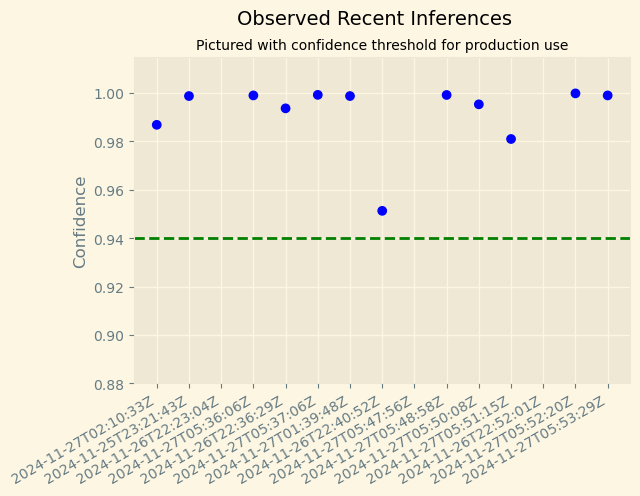

In [68]:
import matplotlib.pyplot as plt
# Populate the data for the x and y axis
x, y = [], []
for obj in json_data:
    inference, timestamp = simple_getter(obj)
    y.append(max(inference))
    x.append(timestamp)

# Todo: here is an visualization example, take some time to build another visual that helps monitor the result
# Plot the data
plt.scatter(x, y, c=['r' if k<.94 else 'b' for k in y ])
plt.axhline(y=0.94, color='g', linestyle='--')
plt.ylim(bottom=.88)

# Add labels
plt.ylabel("Confidence")
plt.suptitle("Observed Recent Inferences", size=14)
plt.title("Pictured with confidence threshold for production use", size=10)

# Give it some pizzaz!
plt.style.use("Solarize_Light2")
plt.gcf().autofmt_xdate()

### Todo: build your own visualization


### Congratulations!

You've reached the end of the project. In this project you created an event-drivent ML workflow that can be incorporated into the Scones Unlimited production architecture. You used the SageMaker Estimator API to deploy your SageMaker Model and Endpoint, and you used AWS Lambda and Step Functions to orchestrate your ML workflow. Using SageMaker Model Monitor, you instrumented and observed your Endpoint, and at the end of the project you built a visualization to help stakeholders understand the performance of the Endpoint over time. If you're up for it, you can even go further with these stretch goals:

* Extend your workflow to incorporate more classes: the CIFAR dataset includes other vehicles that Scones Unlimited can identify with this model.
* Modify your event driven workflow: can you rewrite your Lambda functions so that the workflow can process multiple image inputs in parallel? Can the Step Function "fan out" to accomodate this new workflow?
* Consider the test data generator we provided for you. Can we use it to create a "dummy data" generator, to simulate a continuous stream of input data? Or a big paralell load of data?
* What if we want to get notified every time our step function errors out? Can we use the Step Functions visual editor in conjunction with a service like SNS to accomplish this? Try it out!


